In [1]:
import cv2 # computer vision library
import helpers # helper functions

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # for loading in images

%matplotlib inline


# Image data directories
IMAGE_DIR_TRAINING = "traffic_light_images/training/"
IMAGE_DIR_TEST = "traffic_light_images/test/"


# Using the load_dataset function in helpers.py
# Load training data
IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TRAINING)


# This function should take in an RGB image and return a new, standardized version
def standardize_input(image):
    
    standard_im = np.copy(image)
    standard_im = cv2.resize(standard_im, (32,32))
    
    return standard_im


def one_hot_encode(label):
    
    one_hot_encoded = [] 
    if label == "red":
        one_hot_encoded = [1,0,0]
    elif label == "yellow":
        one_hot_encoded = [0,1,0]
    elif label == "green":
        one_hot_encoded = [0,0,1]
    return one_hot_encoded


def standardize(image_list):
    
    # Empty image data array
    standard_list = []

    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]

        # Standardize the image
        standardized_im = standardize_input(image)

        # One-hot encode the label
        one_hot_label = one_hot_encode(label)    

        # Append the image, and it's one hot encoded label to the full, processed list of image data 
        standard_list.append((standardized_im, one_hot_label))
        
    return standard_list

# Standardize all training images
STANDARDIZED_LIST = standardize(IMAGE_LIST)

# 版本4
- 裁剪
- 模糊
- 创建蒙版
- 判断选中区域中 各颜色像素占比

In [2]:
# 裁剪图片, 裁剪为 20*24 的图像
def crop_image(image):
    row_crop = 4
    col_crop = 6
    return image[row_crop:-row_crop,col_crop:-col_crop,:]

In [3]:
# blur
# http://setosa.io/ev/image-kernels/
def blur(image):
    blur_kernel = np.array([[ 0.0625, 0.125, 0.0625], 
                   [ 0.125, 0.25, 0.125], 
                   [ 0.0625, 0.125, 0.0625]])
    blur_image = cv2.filter2D(image, -1, blur_kernel)
    # plt.imshow(blur_image)
    # plt.title("blur_image")
    # plt.show()
    return blur_image

In [4]:
# 创建蒙版 明度(v)
def create_v_mask(rgb_image):
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    sum_brightness = np.sum(hsv_image[:,:,2])
    area = 20*24
    avg_v = int(sum_brightness/area)
    
    v_lower = np.array([0,0,0])
    v_upper = np.array([179,255,avg_v])
    v_mask = cv2.inRange(hsv_image, v_lower, v_upper)
    return v_mask

In [5]:
# 创建蒙版 饱和度(s)
def create_s_mask(rgb_image):
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    sum_s = np.sum(hsv_image[:,:,1])
    area = 20*24
    avg_s = int(sum_s/area)
    
    s_lower = np.array([0,0,0])
    s_upper = np.array([179,avg_s,255])
    s_mask = cv2.inRange(hsv_image, s_lower, s_upper)
    return s_mask

In [6]:
def create_feature(rgb_image, show=0):
    croped_image = crop_image(rgb_image)
    blur_image = blur(croped_image)
    v_mask = create_v_mask(blur_image)
    s_mask = create_s_mask(blur_image)
    
    # 合并蒙版
    merge_mask = cv2.bitwise_or(v_mask, s_mask)
    
    # 遮盖图像 rgb
    masked_image = np.copy(croped_image)
    masked_image[merge_mask != 0] = [0, 0, 0]
    
    hsv_image = cv2.cvtColor(masked_image, cv2.COLOR_RGB2HSV)
    
    h = hsv_image[:,:,0]
    s = hsv_image[:,:,1]
    v = hsv_image[:,:,2]
    
    
    
    # 未被遮盖的像素总数
    sum_pix = 20*24 - np.sum(merge_mask)/255
    if sum_pix == 0:
        # print("no pix selected")
        return [0,0,0]
    
    # 设定颜色区间
    red_lower = np.array([160,43,46])  # 可以选中红, 适当缩小范围
    red_upper = np.array([177,255,255])  # 可以选中红, 适当缩小范围
    yellow_lower = np.array([10,43,46])  # 适当放大黄色范围
    yellow_upper = np.array([25,255,255])
    green_lower = np.array([35,43,46])  
    green_upper = np.array([100,255,255])  # 绿色有些图片中偏向青蓝色,放宽h值范围
    
    # 计算三种颜色的像素的占比判断  (该颜色像素数量 / 未被遮盖的像素数量)
    pixs_r = cv2.inRange(hsv_image, red_lower, red_upper).sum() / (255*sum_pix)
    pixs_y = cv2.inRange(hsv_image, yellow_lower, yellow_upper).sum() / (255*sum_pix)
    pixs_g = cv2.inRange(hsv_image, green_lower, green_upper).sum() / (255*sum_pix)
    
    
    # 测试用, 显示参数和图片
    if show == 1:
        print(pixs_r, pixs_y, pixs_g)
        
        f, axs = plt.subplots(2, 4, figsize=(20,8))
        ax0 = axs[0,0]
        ax0.imshow(rgb_image)
        ax0.set_title("rgb_image")
        ax1 = axs[0,1]
        ax1.imshow(croped_image)
        ax1.set_title("croped_image")
        ax2 = axs[0,2]
        ax2.imshow(blur_image)
        ax2.set_title("blur_image")
        ax3 = axs[0,3]
        ax3.imshow(masked_image)
        ax3.set_title("masked_image")
        
        ax4 = axs[1,0]
        ax4.imshow(v_mask, cmap='gray')
        ax4.set_title("v_mask")
        ax5 = axs[1,1]
        ax5.imshow(s_mask, cmap='gray')
        ax5.set_title("s_mask")
        ax6 = axs[1,2]
        ax6.imshow(merge_mask, cmap='gray')
        ax6.set_title("merge_mask")
        ax7 = axs[1,3]
        ax7.bar(['r', 'y', 'g'], [pixs_r, pixs_y, pixs_g])
        ax7.set_title("histogram")
        plt.show()
    
    
    if ((pixs_r > pixs_g) and (pixs_r > pixs_y)):
        return [1,0,0]
    elif ((pixs_y > pixs_r) and (pixs_y > pixs_g)):
        return [0,1,0]
    elif ((pixs_g > pixs_r) and (pixs_g > pixs_y)):
        return [0,0,1]
    
    else:
        return [1,0,0]


1.0 0.0 0.0


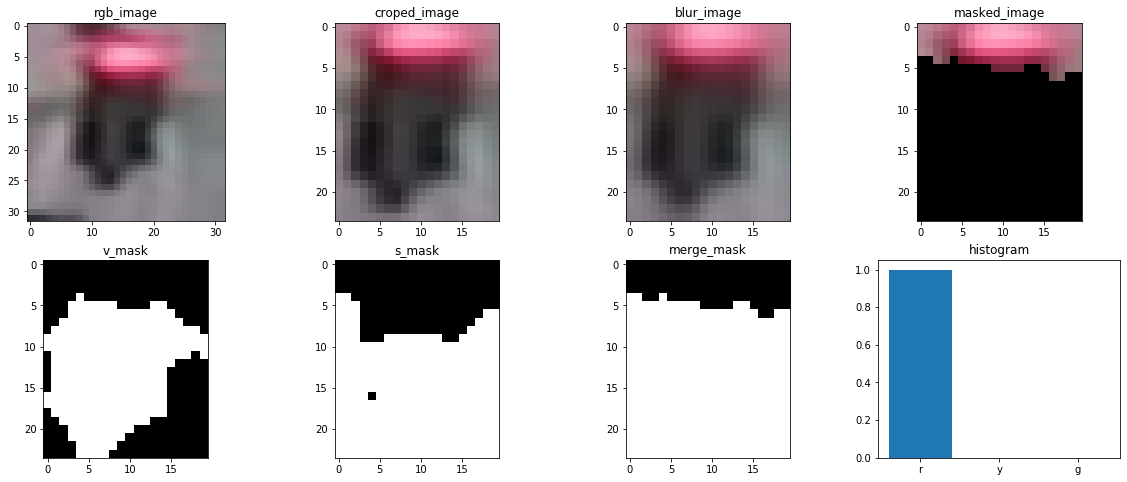

test_label [1, 0, 0]   predicted_label [1, 0, 0]


In [7]:
image_num = 100
test_im = STANDARDIZED_LIST[image_num][0]
test_label = STANDARDIZED_LIST[image_num][1]
predicted_label = create_feature(test_im, show=1)
print("test_label", test_label, "  predicted_label", predicted_label) 

In [8]:
def estimate_label(rgb_image):
    
    ## TODO: Extract feature(s) from the RGB image and use those features to
    ## classify the image and output a one-hot encoded label
    predicted_label = create_feature(rgb_image)
    
    return predicted_label 


In [9]:
# Using the load_dataset function in helpers.py
# Load test data
TEST_IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TEST)

# Standardize the test data
STANDARDIZED_TEST_LIST = standardize(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

In [10]:
# Constructs a list of misclassified images given a list of test images and their labels
# This will throw an AssertionError if labels are not standardized (one-hot encoded)

def get_misclassified_images(test_images):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]
        assert(len(true_label) == 3), "The true_label is not the expected length (3)."

        # Get predicted label from your classifier
        predicted_label = estimate_label(im)
        assert(len(predicted_label) == 3), "The predicted_label is not the expected length (3)."

        # Compare true and predicted labels 
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label))
            
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels


# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))


Accuracy: 0.9696969696969697
Number of misclassified images = 9 out of 297


In [11]:
# Importing the tests
import test_functions
tests = test_functions.Tests()

if(len(MISCLASSIFIED) > 0):
    # Test code for one_hot_encode function
    tests.test_red_as_green(MISCLASSIFIED)
else:
    print("MISCLASSIFIED may not have been populated with images.")


**<span style="color: green;">TEST PASSED</span>**

predicted_label [1, 0, 0] true_label [0, 1, 0]
predicted_label [1, 0, 0] true_label [0, 0, 1]
predicted_label [1, 0, 0] true_label [0, 0, 1]
predicted_label [0, 0, 0] true_label [1, 0, 0]
predicted_label [1, 0, 0] true_label [0, 0, 1]
predicted_label [1, 0, 0] true_label [0, 0, 1]
predicted_label [1, 0, 0] true_label [0, 0, 1]
predicted_label [0, 1, 0] true_label [0, 0, 1]
predicted_label [1, 0, 0] true_label [0, 0, 1]


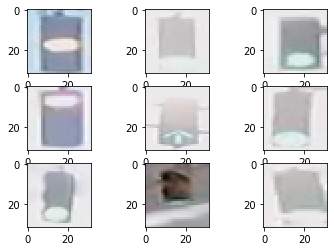

In [13]:
for i in range(9):
    plt.subplot(331+i)
    plt.imshow(MISCLASSIFIED[i][0])
    
for i in range(len(MISCLASSIFIED)):
    print("predicted_label", MISCLASSIFIED[i][1], "true_label", MISCLASSIFIED[i][2])

0.0 0.0 0.0


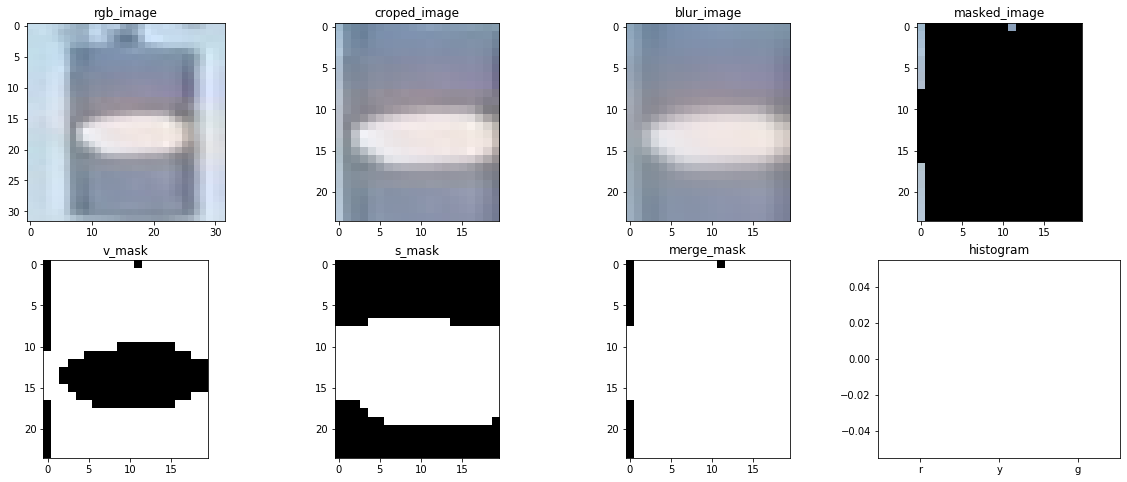

[1, 0, 0]

In [14]:
i = 0
create_feature(MISCLASSIFIED[i][0], show=1)